In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df = pd.read_csv('/content/data_2005.csv')
df.head()

,Unnamed: 0,Time,Rain_rate,Rain_Attenuation
0,0,2.083222,0.123969,0.277891
1,1,2.083502,0.122079,0.374563
2,2,2.083782,0.120313,0.309713
3,3,2.084062,0.118503,0.406240
4,4,2.084342,0.116721,0.329704


In [ ]:
data = df[['Time','Rain_Attenuation']]
data.head()

,Time,Rain_Attenuation
0,2.083222,0.277891
1,2.083502,0.374563
2,2.083782,0.309713
3,2.084062,0.406240
4,2.084342,0.329704


In [ ]:
def decimal_time(time):
    hours = int(time)
    minutes = (time*60) % 60
    seconds = (time*3600) % 60
    f =  (time*3600000000) % 1000000
    return ("%d:%02d:%02d.%03d" % (hours, minutes, seconds,f))

(87369, 2) (87387, 4)
                        Time  Rain_Attenuation
0 1900-01-01 02:04:59.599919          0.277891
1 1900-01-01 02:05:00.607920          0.374563
2 1900-01-01 02:05:01.615920          0.309713
3 1900-01-01 02:05:02.623920          0.406240
4 1900-01-01 02:05:03.631920          0.329704


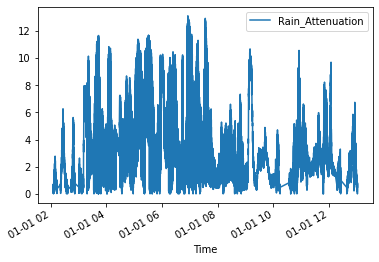

In [ ]:
data['Time'] = data['Time'].apply(lambda x : decimal_time(x))
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f')
data = data.drop_duplicates(subset = ['Time'])
print(data.shape, df.shape)
data1 = data.set_index('Time')
print(data.head())
data1.plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dat = data1.values
sc = MinMaxScaler(feature_range=(0,1))
scaled = sc.fit_transform(dat)

train = scaled[:52370, :]
val =  scaled[52370:69870,:]
test = scaled[69870:, :]
train.shape, test.shape, val.shape

((52370, 1), (17499, 1), (17500, 1))

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []

n_future = 60
n_past = 30

for i in range(0,len(train)-n_past-n_future+1):
    x_train.append(train[i : i + n_past , 0])     
    y_train.append(train[i + n_past : i + n_past + n_future , 0 ])

for i in range(0,len(val)-n_past-n_future+1):
    x_val.append(val[i : i + n_past , 0])     
    y_val.append(val[i + n_past : i + n_past + n_future , 0 ])

for i in range(0,len(test)-n_past-n_future+1):
    x_test.append(test[i : i + n_past , 0])     
    y_test.append(test[i + n_past : i + n_past + n_future , 0 ])


x_train , y_train = np.array(x_train), np.array(y_train)
x_test , y_test = np.array(x_test), np.array(y_test)
x_val , y_val = np.array(x_val), np.array(y_val)

x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )
x_test = np.reshape(x_test, (x_test.shape[0] , x_test.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0] , x_val.shape[1], 1))

x_train.shape,y_train.shape, x_test.shape,y_test.shape, x_val.shape, y_val.shape

((52281, 30, 1),
 (52281, 60),
 (17410, 30, 1),
 (17410, 60),
 (17411, 30, 1),
 (17411, 60))

In [ ]:
model = Sequential()

model.add(Convolution1D(4096, kernel_size=3,padding = 'same',activation='relu', input_shape=(x_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))

model.add(Convolution1D(2048,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())

model.add(Dense(2048, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_future, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 3)
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32 , validation_data=(x_val, y_val), callbacks = [es], verbose = 1)

Epoch 1/50
1634/1634 [==============================] - 215s 113ms/step - loss: 0.1070 - val_loss: 0.0613
Epoch 2/50
1634/1634 [==============================] - 185s 113ms/step - loss: 0.1039 - val_loss: 0.0613
Epoch 3/50
1634/1634 [==============================] - 185s 113ms/step - loss: 0.1039 - val_loss: 0.0612
Epoch 4/50
1634/1634 [==============================] - 185s 113ms/step - loss: 0.1030 - val_loss: 0.0613
Epoch 5/50
1634/1634 [==============================] - 185s 113ms/step - loss: 0.1041 - val_loss: 0.0613
Epoch 6/50
1634/1634 [==============================] - 185s 113ms/step - loss: 0.1037 - val_loss: 0.0613
Epoch 00006: early stopping


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 4096)          16384     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 4096)          16384     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 4096)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 2048)          25167872  
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 2048)          8192      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 2048)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14336)             0

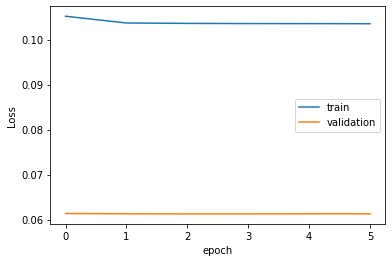

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

plt.show()

In [ ]:
predicted = model.predict(x_test)
predicted = np.reshape(predicted,(predicted.shape[0],predicted.shape[1]))
predicted = sc.inverse_transform(predicted)
ttest = sc.inverse_transform(y_test)
score = math.sqrt(mean_squared_error(ttest,predicted))
print("The rmse score of Rain Attenuation : ",score)

The rmse score of Rain Attenuation :  2.9924700568576905


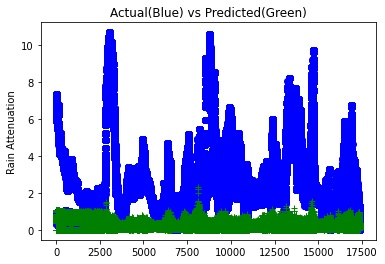

In [ ]:
plt.plot(ttest, 'ro',color = 'blue', label = 'Actual')
plt.plot(predicted,'r+',  color = 'green', label = 'Predicted')
plt.title('Actual(Blue) vs Predicted(Green)')
plt.ylabel('Rain Attenuation')
plt.show()

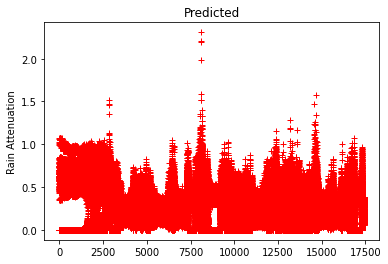

In [ ]:
plt.plot(predicted, 'r+')
plt.title('Predicted')
plt.ylabel('Rain Attenuation')
plt.show()

In [ ]:
t =  model.predict(x_train)
t = np.reshape(t,(t.shape[0],t.shape[1]))
t = sc.inverse_transform(t)
ttrain = sc.inverse_transform(y_train)
score1 = math.sqrt(mean_squared_error(ttrain,t))
print("The rmse score of Rain Attenuation : ",score1)

The rmse score of Rain Attenuation :  4.220859508378055


In [ ]:
predicted[:1] # predicted first 60 seconds of rain attenuation

array([[1.30060887e-08, 6.77098632e-01, 1.90287075e-08, 1.76521979e-08,
        6.88420892e-01, 1.14000285e-08, 5.65079326e-08, 6.21412933e-01,
        7.72194841e-09, 6.57963328e-09, 6.54104233e-01, 3.81350951e-09,
        2.05572093e-08, 5.91862857e-01, 1.98678443e-08, 1.11417267e-08,
        6.31642282e-01, 2.78098566e-09, 2.57661288e-08, 6.07146740e-01,
        4.69549466e-09, 1.66247620e-08, 6.97604716e-01, 7.30182315e-09,
        2.74950374e-09, 7.03276873e-01, 6.56779742e-09, 1.86972855e-08,
        6.54082417e-01, 6.04622397e-09, 4.38860468e-08, 7.38593459e-01,
        3.94830764e-08, 4.01121669e-09, 6.53825164e-01, 5.09626918e-09,
        6.25998808e-09, 6.95396245e-01, 2.66154938e-08, 8.23120416e-09,
        7.79871047e-01, 3.21909721e-09, 1.09838538e-08, 7.03207552e-01,
        1.72015682e-08, 2.98832359e-09, 6.17255986e-01, 5.86058135e-09,
        2.73205947e-09, 6.33930922e-01, 7.57045449e-09, 8.21022450e-09,
        5.71520269e-01, 7.58305685e-09, 1.37873553e-08, 6.635804

In [ ]:
ttest[:1]# actual first 60 seconds of rain attenuation

array([[0.4863931 , 6.1096525 , 0.93802633, 0.80087681, 6.0924591 ,
        0.57946145, 0.47976963, 6.6557815 , 0.64998772, 0.70990312,
        6.2856115 , 0.44567526, 0.82983904, 6.1649184 , 0.80096164,
        0.63962572, 6.1103466 , 0.81093895, 0.63842396, 6.2718592 ,
        0.85456189, 0.67741301, 6.5479161 , 0.59402715, 0.77328302,
        7.1811098 , 0.43848655, 0.71462997, 6.7417819 , 0.86233653,
        0.86406537, 6.327605  , 0.71256264, 0.63866204, 6.2677843 ,
        0.39102295, 0.57119504, 6.4135442 , 0.50237194, 0.7004401 ,
        6.3500915 , 0.53044744, 0.72251712, 6.3263414 , 0.77745445,
        0.6293441 , 7.3442018 , 0.51665262, 0.61349154, 7.1824108 ,
        0.54376722, 0.64023796, 6.8949164 , 0.68273749, 0.72967855,
        6.7080391 , 0.61972444, 0.64035134, 6.7887398 , 0.60699375]])

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
'''
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

loaded_model.summary()
'''

'\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n \n\n# evaluate loaded model on test data\nloaded_model.compile(optimizer=\'adam\', loss=\'mean_squared_error\',metrics=[\'acc\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))\n\nloaded_model.summary()\n'